<a href="https://colab.research.google.com/github/metbrian/DSPS_BFrei/blob/main/HW7/clustering_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pylab as pl
import sklearn as skl
from sklearn import cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from scipy.spatial import distance_matrix
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


read the data in https://github.com/fedhere/DSPS/tree/master/HW10

In [ ]:
genes = pd.read_csv('https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW7/kidpackgenes.csv')

# 1. explore the data. 

In [ ]:
genes.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,55,56,57,58,60,61,64,65,66,68,69,72,73,74,75,76,77,78,79,81,83,84,85,86,87
0,1,-0.146342,-0.520637,0.175828,-0.323736,0.172691,0.025156,0.024812,0.172268,0.207188,0.026710,0.370241,0.390749,-0.103504,0.100439,-0.375930,0.277828,-0.130996,-0.009923,-0.399163,-0.127337,0.234942,0.628659,0.032232,-0.051522,0.322164,0.677058,0.626976,-0.075533,0.105881,0.121000,0.544208,0.126653,0.214285,0.426416,-0.385641,0.018007,0.407190,-0.175330,-0.033392,-0.056588,0.380069,0.247337,-0.160898,0.362272,0.190525,0.101010,1.280034,-0.137223,0.013790,0.284715,-0.080554,0.077708,0.071853,-0.225874,-0.148424,-0.104276,0.427028,0.331856,0.167732,-0.576949,0.007349,-0.002330,0.168953,-0.122312,0.240705,-0.347746,-0.001797,-0.260594,0.105968,0.110885,-0.006975,0.550118,0.118934,0.327248
1,2,-0.465767,0.155823,0.226344,-0.547542,0.041096,0.137012,0.102497,-0.034277,0.500871,0.005533,0.394116,0.474481,-0.004962,0.828600,-0.458895,0.002399,-0.237577,-0.135808,-0.470168,0.088704,-0.039030,0.598749,0.216180,-0.086335,0.509942,0.741002,0.819442,-0.287630,0.253042,-0.122267,0.048518,0.164557,0.208869,0.351322,-0.096956,0.158479,0.566782,-0.171814,0.187912,0.103039,0.605204,-0.010693,0.145773,0.431635,0.408843,0.049612,0.873300,-0.445282,0.050207,0.102510,-0.438553,-0.000697,-0.232677,-0.684507,-0.138210,-0.265029,0.036734,0.474339,0.096666,-0.672424,-0.022295,0.094897,-0.123030,-0.382857,0.371435,-0.447105,-0.134904,-0.250699,0.164698,-0.035022,0.250384,0.463746,-0.514230,0.200956
2,3,-0.088964,-0.208241,-0.151039,-0.288229,-0.425568,0.121006,-0.097883,-0.007597,0.329636,-0.222495,0.102853,0.078648,-0.175050,0.064488,-0.243920,-0.036435,-0.815732,-0.094098,-0.786828,-0.497140,-0.211386,0.249518,0.195911,-0.136115,-0.079168,0.461258,0.268629,0.075221,0.447445,-0.380212,-0.127944,-0.514944,0.204084,-0.132934,-0.717559,-0.723766,-0.009187,-0.026201,-0.428314,-0.243215,0.017108,0.199045,0.335860,-0.070557,0.296754,-0.147136,0.479280,-0.445308,0.173236,0.198668,-0.086679,-0.161494,0.043638,-0.115692,-0.020515,-0.035825,0.120870,0.474513,0.061214,-1.124604,0.085298,-0.160597,-0.223782,0.135259,-0.014990,-0.458297,-0.050852,-0.168500,0.078716,-0.032231,-0.116947,-0.199880,-0.415793,-0.032004
3,4,-0.327696,-1.714948,0.068710,-0.168257,-0.471577,0.279013,-0.060734,-0.222574,0.658097,0.129876,0.531540,-0.109510,-0.178851,0.007126,-0.341273,-0.601923,-0.239953,0.307493,-0.264719,-0.105008,0.587365,0.220183,-0.380904,0.073614,0.082134,0.554048,0.300248,0.479317,0.110226,0.060817,0.080991,-0.165642,-0.327310,0.542784,-0.053313,-0.447296,0.701035,0.282916,0.272387,-0.124356,-0.091246,0.121123,-0.091694,0.174790,0.327808,1.024205,0.471022,0.087155,0.398634,-0.053726,0.354639,0.034264,0.684986,0.314253,0.181046,-0.273637,0.234412,0.066505,0.104653,-0.230860,0.074711,0.066029,0.276241,-0.331959,0.153765,-0.140409,-0.119515,-0.289881,0.944493,-0.142710,-1.119866,-0.215536,0.345946,0.056442
4,5,-0.092327,-0.660456,0.075948,-0.646501,-0.046137,-0.010305,0.368476,-0.043832,-0.321060,0.116657,0.345860,0.282539,-0.077624,0.826049,-0.136295,-0.686548,-0.580715,0.037365,-0.106896,0.196168,0.201661,0.180436,0.052139,-0.001053,0.152552,0.365342,0.462115,-0.155553,0.239003,-0.231050,0.629987,0.020532,0.063029,-0.981387,-0.280845,-0.164185,0.846567,-0.399580,0.340091,0.044768,0.334025,0.032647,0.466371,-0.118516,0.665676,0.443797,0.474259,-0.349966,0.100411,-0.265844,-0.333114,0.914200,-0.088706,-0.457485,-0.046669,0.171069,0.127423,0.483766,0.607528,-1.412080,-0.281975,0.080899,0.855141,-0.487761,-0.033032,0.394082,0.173515,-0.194819,0.149131,-0.097285,-0.288192,-0.491920,-0.722120,0.055477


In [ ]:
genes.tail()

,Unnamed: 0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,55,56,57,58,60,61,64,65,66,68,69,72,73,74,75,76,77,78,79,81,83,84,85,86,87
2598,2599,-0.387013,-0.351933,0.363170,-0.532783,-0.405961,-0.350308,0.607677,-0.033040,0.388872,-0.238816,0.212705,0.143891,-0.273079,0.293993,-0.416901,-0.563850,0.141600,0.390180,0.440435,-0.382377,-0.250367,0.407607,0.163053,-0.299922,0.514493,0.087441,0.869680,-0.188036,-0.095608,-0.067924,0.376718,0.248722,-0.360433,-0.218977,0.043815,-0.301484,0.293724,-0.465075,0.531631,-0.214568,0.555792,-0.121501,-0.295885,-0.072694,0.485399,0.010489,0.410930,-0.239219,0.072331,0.022814,-0.643175,0.319920,-0.512436,-0.528757,-0.333128,-0.242071,-0.051524,0.537861,0.980160,-0.183555,-0.265593,0.516068,0.319227,-0.231068,0.013212,0.122758,0.260209,0.014410,0.155995,-0.184897,0.073087,-0.095532,-0.348209,0.390796
2599,2600,-0.167853,-0.316385,0.087252,-0.117309,-0.871179,-0.468648,0.068771,-0.143372,2.719371,-0.327453,-1.021617,-0.672952,1.442040,2.676722,-0.478715,-0.686145,-0.738154,-0.859194,0.163937,1.415368,-0.640730,0.023372,-0.694698,-0.533619,0.138107,-0.498123,-0.127501,-0.391434,-0.639445,-0.556260,-0.659278,-0.518336,-2.183013,0.026728,1.893199,1.859095,-0.462593,-0.666251,-0.767953,1.688372,-0.343924,-0.311581,0.136260,-0.596877,-0.620736,-0.572075,-0.678667,-0.638840,-0.485775,-0.798542,-0.258415,-0.342933,-0.524371,-0.015912,0.039642,-0.345795,-0.382013,-0.359992,-0.689863,-0.512740,-0.799138,-0.523692,-0.322469,-0.576968,2.107459,-0.798081,-0.395218,-0.850703,-0.268263,-0.573838,2.586922,-0.532048,-0.416461,0.340277
2600,2601,-0.793226,-0.316129,-0.330165,-1.328636,-0.776035,-0.114225,0.255864,-0.005224,0.380932,-0.108821,-0.015929,-0.304623,-0.301012,-0.046252,-0.794667,-0.725348,-0.409060,-0.404577,-0.182002,-0.260074,-0.183700,0.219292,0.083222,-0.362284,0.272878,-0.274763,0.323319,-0.659963,0.038166,-0.388417,-0.428360,0.097290,-0.288769,0.086806,-0.307646,0.044675,-0.022537,-0.647173,-0.036910,0.046848,0.006340,-0.500023,-0.690130,-0.052640,0.002277,-0.377863,0.068401,-0.578832,-0.142472,0.359693,-1.090517,-0.352789,-1.296877,-1.188341,-0.381231,-0.519686,-0.023191,0.238098,-0.432602,-1.050914,-0.364255,-0.127450,0.211059,-0.696601,-0.403937,-0.203626,0.127042,-0.407454,0.075773,-0.581201,-0.471235,-0.151244,-0.742843,0.051671
2601,2602,-0.136738,-0.473996,-0.065985,-0.389660,-0.246289,-0.234996,0.446785,-0.226391,-0.231487,0.046120,-0.323124,0.166398,-0.258344,0.074904,-0.444131,0.110371,-0.416839,-0.512814,-0.065219,-0.220263,-0.206653,-0.004274,0.345421,0.039575,0.337348,-0.487231,0.231773,-0.622266,-0.094176,-0.307941,-0.104431,-0.022862,-0.507242,-0.742570,-0.136429,-0.127410,0.211714,-0.340207,0.175548,-0.252186,0.320918,0.277043,0.175873,0.222156,0.142569,-0.130999,0.413624,0.030738,-0.286052,-0.601512,-0.207631,0.082818,-0.488113,-0.220010,-0.057875,0.018704,-0.005366,0.119388,-0.074321,-0.724086,-0.706197,-0.063034,0.011872,-0.681008,-0.009820,0.317453,0.242149,-0.427865,0.213364,-0.634293,-0.008888,-0.313828,-0.471017,-0.023894
2602,2603,-0.202742,-0.143678,0.357981,-0.806248,0.108837,0.101487,0.813528,0.589563,0.368431,0.414574,0.824976,0.609290,0.187906,0.518025,0.350774,-0.157054,0.745152,0.068545,0.397408,0.235402,0.260047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
genes.describe()

,Unnamed: 0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,55,56,57,58,60,61,64,65,66,68,69,72,73,74,75,76,77,78,79,81,83,84,85,86,87
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000
mean,1302.000000,-0.074268,-0.005045,0.005219,-0.079438,-0.042794,0.015155,-0.059323,-0.039752,-0.087955,0.000902,-0.041196,-0.015011,-0.034671,-0.112678,-0.048054,-0.012752,-0.002154,-0.023367,-0.008875,-0.043155,-0.010581,-0.046829,-0.017217,-0.018598,-0.064104,-0.019154,-0.013590,-0.050083,-0.005277,-0.012565,-0.020906,0.000761,0.024507,-0.113173,-0.029828,-0.061770,-0.013789,-0.023064,-0.029895,-0.003806,-0.054352,-0.002723,-0.039034,-0.017288,-0.030980,-0.004383,-0.053051,-0.068682,-0.009360,-0.075672,-0.093618,-0.033892,-0.112174,-0.074965,-0.014106,-0.071248,0.035666,-0.008715,-0.017194,-0.200595,-0.037934,-0.015484,-0.019799,-0.031708,-0.038404,-0.032761,-0.001378,-0.022449,0.026098,-0.064188,-0.027919,0.007936,-0.114165,-0.010700
std,751.565699,0.493931,0.346347,0.331848,0.692972,0.428889,0.339398,0.380021,0.351449,0.455828,0.345493,0.362652,0.447326,0.540023,0.580710,0.496429,0.543310,0.465740,0.387973,0.397993,0.425933,0.403002,0.451923,0.428803,0.336798,0.462792,0.488627,0.407588,0.467046,0.371725,0.383642,0.406435,0.441833,0.378632,0.629972,0.416798,0.493904,0.443052,0.431308,0.421408,0.532214,0.398046,0.461719,0.483934,0.392557,0.403347,0.448873,0.492421,0.461677,0.386885,0.410835,0.560112,0.405502,0.514117,0.544044,0.397607,0.357038,0.409143,0.434971,0.381831,0.653300,0.359162,0.346666,0.425046,0.428582,0.484102,0.405609,0.317786,0.353947,0.395140,0.397782,0.457248,0.493876,0.533757,0.335695
min,1.000000,-2.205219,-1.779857,-3.072872,-3.491640,-2.479485,-2.720292,-1.807954,-1.835609,-3.214822,-2.205530,-2.969586,-3.050465,-2.917858,-3.181177,-2.069074,-2.443847,-2.939125,-2.537342,-2.928132,-2.786925,-2.929382,-3.110417,-2.933780,-2.309182,-2.283125,-2.895753,-3.055124,-2.325877,-2.342742,-2.547162,-2.730039,-2.805689,-2.365530,-3.463368,-2.913498,-3.193134,-3.083389,-2.356298,-3.115594,-3.055898,-2.517066,-3.152997,-2.251476,-3.860232,-2.786184,-2.578267,-2.972079,-2.115559,-2.544261,-3.074444,-2.650749,-2.215245,-2.421503,-2.707306,-2.096697,-2.189115,-3.551347,-3.030329,-2.257671,-3.547477,-2.572353,-2.898716,-2.360366,-3.125898,-2.946771,-3.281180,-2.787443,-1.938678,-2.932198,-3.054572,-3.013660,-2.955538,-2.909000,-1.563549
25%,651.500000,-0.378801,-0.212649,-0.179065,-0.506899,-0.275926,-0.144605,-0.309324,-0.234284,-0.332753,-0.210667,-0.261666,-0.280333,-0.321668,-0.392210,-0.350457,-0.324113,-0.252442,-0.238936,-0.230974,-0.293005,-0.216682,-0.316509,-0.260370,-0.224494,-0.316412,-0.285549,-0.246799,-0.343867,-0.203991,-0.234622,-0.254897,-0.243294,-0.138720,-0.494179,-0.292053,-0.339179,-0.277470,-0.293535,-0.261606,-0.314649,-0.284501,-0.278219,-0.345054,-0.203879,-0.272156,-0.286396,-0.351555,-0.325736,-0.191825,-0.297874,-0.431941,-0.271377,-0.418970,-0.391202,-0.261430,-0.272787,-0.167300,-0.298374,-0.221744,-0.596937,-0.229019,-0.194918,-0.265233,-0.282190,-0.321877,-0.277627,-0.170285,

# 2 preprocess the data
2.1 whiten the data (scale it) with https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

The last row contains Nan values, we're going to drop it to work with the data without running into problems later

In [ ]:
genes.drop(genes.shape[0]-1, inplace= True)
scaledgenes = skl.preprocessing.scale(genes, axis=0)

In [ ]:
scaledgenes.shape

(2602, 75)

In [ ]:
scaledgenes.mean(0).round(2), scaledgenes.std(0)

(array([-0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,
        -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,
        -0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,
        -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        -0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
         0., -0.,  0., -0., -0., -0., -0., -0., -0.,  0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]))

2.1 use TSNE to make a projection of the data on an optimal 2D plane using https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
twodproj = TSNE(n_components=2, init='random').fit_transform(scaledgenes)

In [ ]:
twodproj.shape

(2602, 2)

2.3 plot the TSNE projection


Text(0.5, 1.0, 'TSNE Projection of Data')

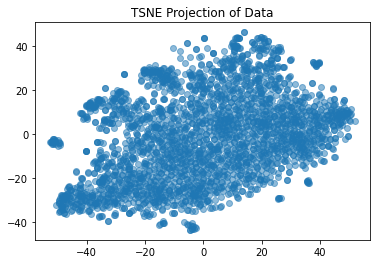

In [ ]:
plot(twodproj[:,0], twodproj[:,1], 'o', alpha = 0.5)
plt.title('TSNE Projection of Data')

2-D TSNE projection of scaledgenes data. 

2.4 calculate a function that measures the intracluster variance (i did it in class)

In [ ]:
#delete
def calICVar(X, centers, labels):
  '''
  The functions receives as arguments a numpy array with the data, 
  an array with the center of the clusters 
  and an array with labels
  '''
  lbl = np.unique(labels)
  #print(lbl.size)
  n_clusters = lbl.size
  clus_var = np.zeros(n_clusters)
  
  for i in range(n_clusters):
    temp = X[labels == lbl[i]]

    # Calculate the distance
    dist = np.sqrt(np.sum((temp-centers[i])**2, axis = 1))
    #print(temp.shape[0], dist.shape)
    # Calculate the variance
    #clus_var[i] = (dist / (temp.shape[0] - 1)).sum()
    clus_var[i] = np.sum(dist**2)
  return np.sum(clus_var)

# 3 K-Means clustering
3.1 cluster the data with K-Means using 1 to 10 clusters. Calculate and plot the intracluster variance as a function of number of clusters and look for an "elbow" in the value of the intracluster variance. What is the optimal number of clusters? discuss

In [ ]:
variances = np.zeros(10)

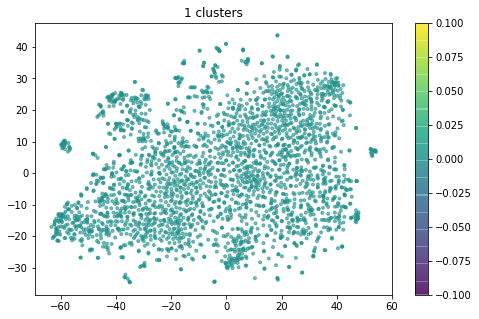

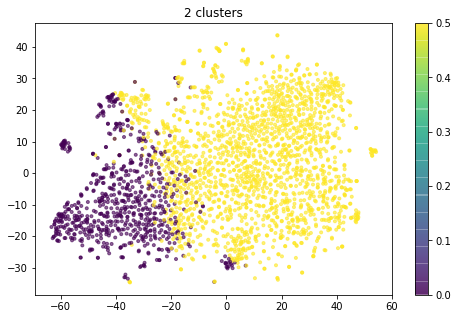

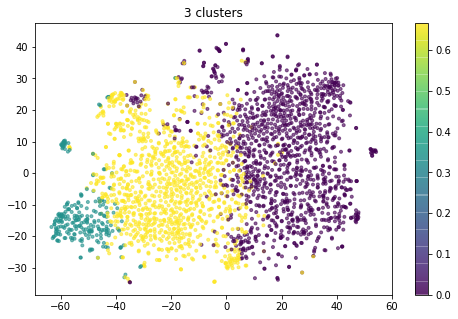

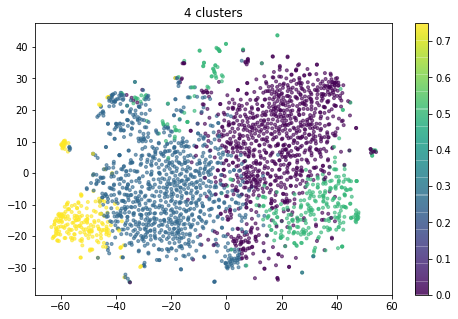

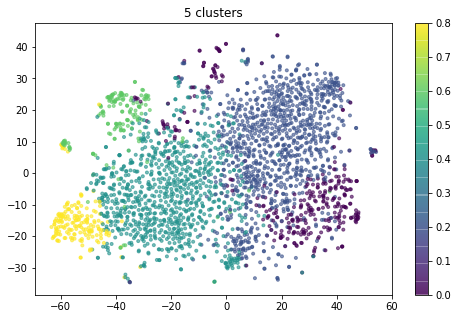

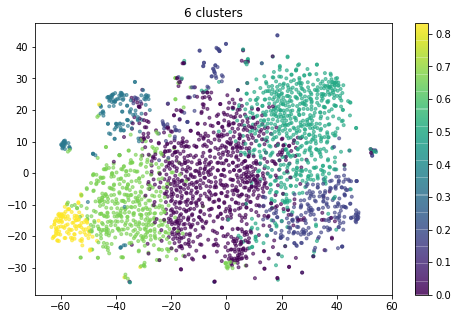

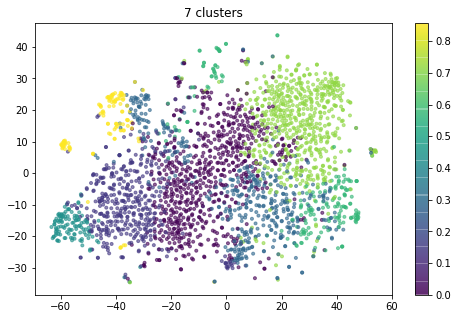

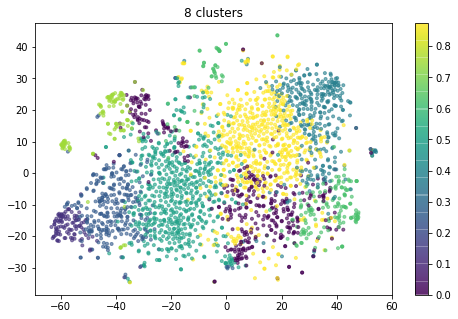

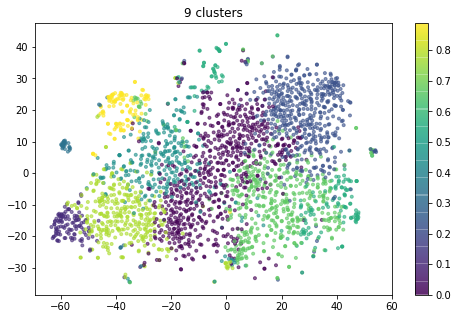

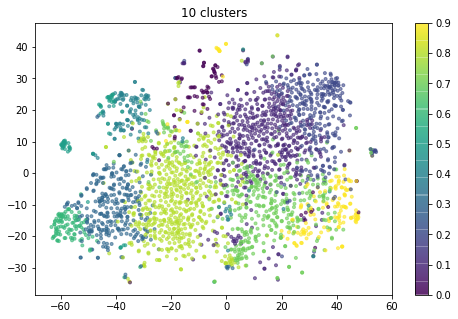

In [ ]:
for i in range(10):
  geneclustersKM = cluster.KMeans(n_clusters=i+1).fit(scaledgenes)
  variances[i] = calICVar(scaledgenes,geneclustersKM.cluster_centers_, geneclustersKM.labels_)
  pl.figure(figsize=(8,5))
  pl.scatter(twodproj[:,0], twodproj[:,1], c=geneclustersKM.labels_/ geneclustersKM.n_clusters,marker='.', alpha=0.6)
  pl.title('{} clusters'.format(i+1))
  pl.colorbar();
pl.show()

Visualization of the clustered dataset for 1-10 clusters

Text(0, 0.5, 'Intracluster Variance')

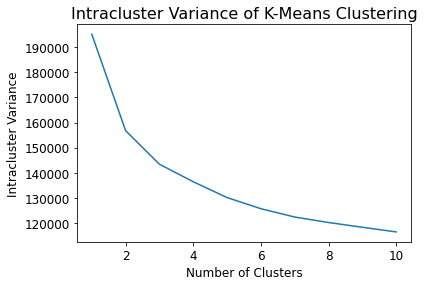

In [ ]:
x = range(1, 11, 1)
pl.rcParams["font.size"] = 12
pl.plot(x, variances)
pl.title('Intracluster Variance of K-Means Clustering', size=16)
pl.xlabel('Number of Clusters')
pl.ylabel('Intracluster Variance')

Figure 2: Intracluster variance based on number of clusters for k-means clustering. Within 10 clusters, it's difficult to find a definitive "elbow" where intracluster stops rapidly decreasing. There may be another drop-off after 10 clusters, since the variances are still very high at 10. Given the information we have, I would recommend using 8 clusters as an ideal number, as the decrease after 8 clusters is slow, and it would save on computational costs (relative to 10 which has only marginally lower intracluster variance). 

# Choose to use DBSCAN or hierarchical clustering (EC also to the other method)

# 4a DBSCAN
4a.1 calculate and plot the distance matrix if you have not yet. Discuss: is there structure?

4a.2 make a histogram of the pairwise distances. You should choose a value to initialize dbscan that is just below the mean

4a.3 initialize the dbscan eps value appropriately and fit a dbscan model to the data plot the 2D TSNE projection colorcoded as before. 

4a.4 How many clusters do you have, how many outliers? is that a significant number?

First, let's compute the distance matrix using scipy's prebuild function

In [ ]:
d_matrix = distance_matrix(scaledgenes,scaledgenes)

Text(0.5, 1.0, 'Distance Matrix Plot for DBSCAN')

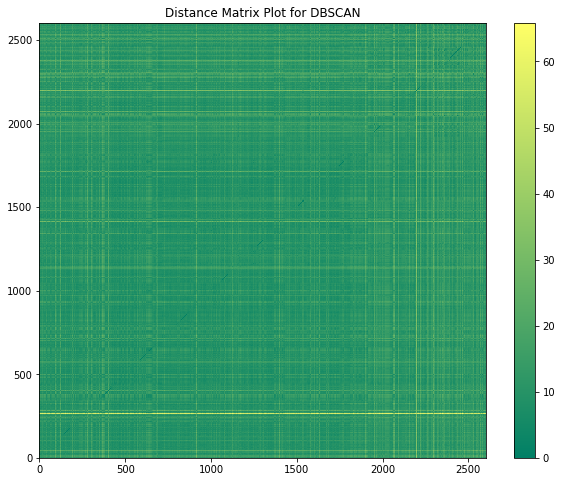

In [ ]:
pl.figure(figsize=(10,8))
pl.pcolormesh(d_matrix, cmap = 'summer')
pl.colorbar()
pl.title('Distance Matrix Plot for DBSCAN')

Distance matrix plot. From this plot we can not tell if there is or not an underlying structure in the data. The most we can tell is an apparent division around a distance of 50-60

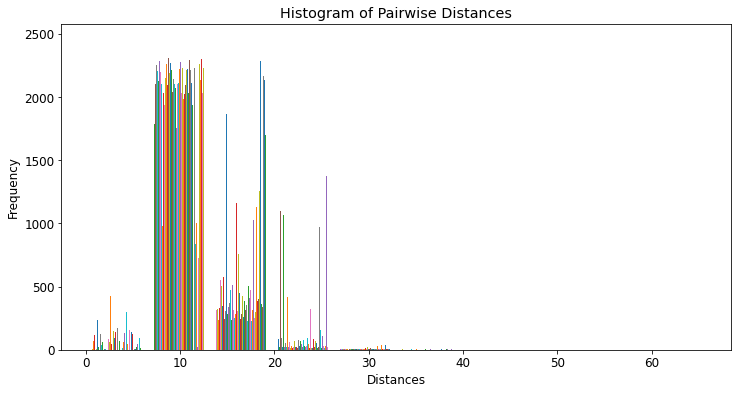

In [ ]:
pl.rcParams["font.size"] = 12
pl.figure(figsize=(12,6))
pl.hist(d_matrix);
pl.xlabel('Distances');
pl.ylabel('Frequency');
pl.title('Histogram of Pairwise Distances')
pl.show()

Pairwise distances histogram. From this plot we can see that the pairwise distances tend to cluster. Each cluster is around 6-8 wide, therefore we can use this range as our eps parameter for DBSCAN.

Furthermore, following the idea proposed in https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/ we run the nearest neighbors method to determine the optimum value for eps

In [ ]:
neigh = NearestNeighbors(n_neighbors=150)
nbrs = neigh.fit(scaledgenes)
distances, indices = nbrs.kneighbors(scaledgenes)

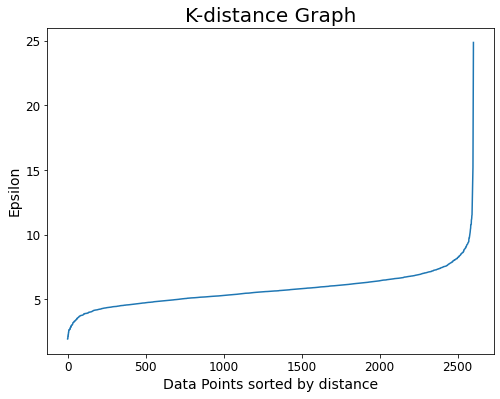

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
pl.rcParams["font.size"] = 12
plt.figure(figsize=(8,6))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

The optimal eps value will epsilon when the curvature is maximum. In this case it is close to 7, which is in agreement with our previous analysis using the histogram

For the value of min_samples we were motivated by this article https://www.sciencedirect.com/science/article/pii/S0169023X06000218, where they proposed that min_samples = ln(N) being N the number of points to be clustered. Using this approach we get min_samples = 8.

In [ ]:
db_scan = cluster.DBSCAN(eps=7, min_samples=8).fit(scaledgenes)

In [ ]:
np.unique(db_scan.labels_)

array([-1,  0,  1])

In [ ]:
#Calculate the number of data points in each cluster
print('Number of data points for each label')
print('Label \t Count')
for i in np.unique(db_scan.labels_):
  print('{} \t {}'.format(i,(db_scan.labels_==i).sum()))

Number of data points for each label
Label 	 Count
-1 	 410
0 	 2181
1 	 11


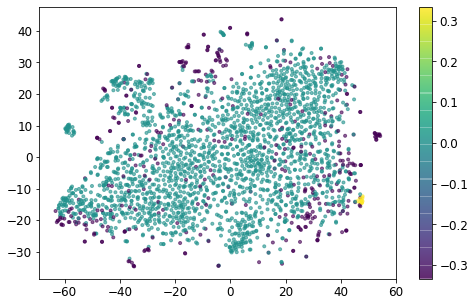

In [ ]:
pl.rcParams["font.size"] = 12
pl.figure(figsize=(8,5))
pl.scatter(twodproj[:,0], twodproj[:,1], marker='.', c=db_scan.labels_/ np.unique(db_scan.labels_).size, alpha=0.6)
pl.title('DBSCAN Clustering')
pl.colorbar();

Clustered data using dbscan. The purple points represents the outliers.
This algorithm gives two clusters besides the outliers, which in comparison with KMeans for three clusters looks significantly different.

There are 410 outliers compared to 11 in the yellow cluster. Furthermore, when we ran the algortihm for a greater number of min_samples (10) there was only one cluster besides the outliers. It could meand that the yellow cluster is in fact no structure of the data and that there is no underlying structure.

This plot is also considerably different from the kmeans plot for 3 clusters

# 4b Agglomerative clustering
 4b.1 cluster the data with the ward linkage


In [ ]:
agg = AgglomerativeClustering(affinity='euclidean', linkage='ward')
agg.fit_predict(scaledgenes)

array([0, 0, 0, ..., 0, 0, 0])

4b.2 calculate the linkage and plot the dendrogram of the clusters  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

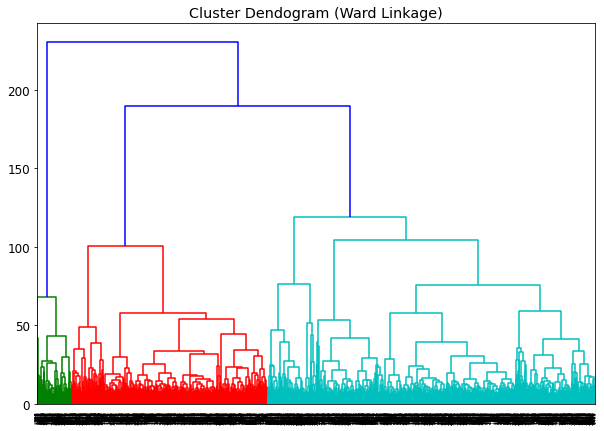

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Cluster Dendogram (Ward Linkage)")  
dend = shc.dendrogram(shc.linkage(scaledgenes, method='ward')) 

Dendogram for ward linkage method of agglomerative clustering. This figure shows a clear representation of how each point was gradually joined into larger and larger clusters based on the ward linkage method, eventually resulting in two groups by the end (after more than 200 steps).

4b.3 repeat with a different linkage and comment on differences

In [ ]:
agg2 = AgglomerativeClustering(affinity='euclidean', linkage='average')
agg2.fit_predict(scaledgenes)

array([0, 0, 0, ..., 0, 0, 0])

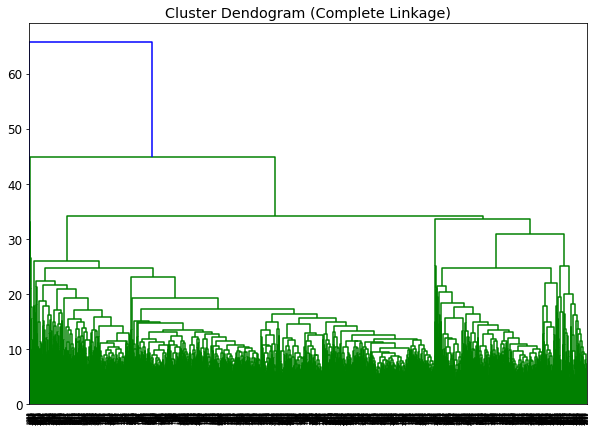

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Cluster Dendogram (Complete Linkage)")  
dend = shc.dendrogram(shc.linkage(scaledgenes, method='complete')) 

Dendogram using the complete, or maximum linkage method. This figure shows a much quicker resolution to 2 clusters in less than 70 steps. The patterns of clustering appear to be slighly more complex than the previous figure, although this may only be because we are able to see these details through a more zoomed in figure (with less steps). 

4b.4 rerun agglomerative cluatering to get the "ideal" number of clusters as decided by k-means. plot the 2D TSNE projection colorcoded as before.

In [ ]:
agg3 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
agg3.fit_predict(scaledgenes)

array([1, 1, 1, ..., 6, 6, 3])

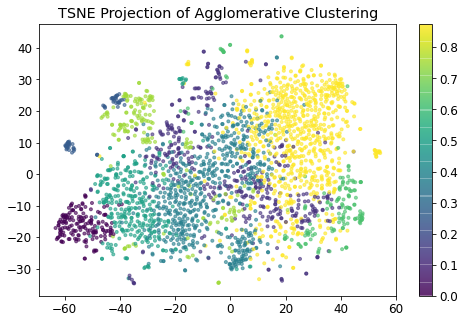

In [ ]:
pl.rcParams["font.size"] = 12
pl.figure(figsize=(8,5))
pl.scatter(twodproj[:,0], twodproj[:,1], marker='.', c=agg3.labels_/ np.unique(agg3.labels_).size, alpha=0.6)
pl.title('TSNE Projection of Agglomerative Clustering')
pl.colorbar();

In this figure the TSNE Projection of Agglomerative Clustering of 8 clusters allows us to easily visualize the groupings. The patterns appear to be very similar to the K-means clustering with 8 groups. Since the agglomerative method is more computationally taxing, it's questionable whether it would be useful to use for this data set. 